<a href="https://colab.research.google.com/github/mysujan/MLTSA25_SShrestha/blob/main/HW3/berprophet_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis.

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality.

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)

Note that the 4 models you will create build incrementally: you are always adding one more piece of a model to the previous one (even when it is not explicitly stated that the new model contains all the components of the previous ones:
- Model 1: trend and seasonality
- Model 2: trend, seasonality, and exogenous weather variables
- Model 3: trend, seasonality, exogenous weather variables, holidays
- Model 4: trend, seasonality, exogenous weather variables, holidays, MCMC implementation (same model, different optimization)



In [1]:
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib



# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis.
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


In [2]:
!pip install prophet


In [3]:
import prophet

In [4]:
from prophet import Prophet
from prophet import diagnostics

# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response.

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [18]:
a = []
for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
    url = f"https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/refs/heads/master/uber-trip-data/uber-raw-data-{mon}14.csv"
    a.append(pd.read_csv(url))


In [19]:
uberrides = pd.concat(a)

In [20]:
uberrides.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day.
Note that at this stage this is not the kind of time series you need. You need number of rides per unit time (e.g. per day) and we have timsetamp of each ride.
To obtain that you can use the ```groupby()``` method of your dataframe. Before that, convert the date time column to ```pd.datetime``` type (this may take a while), then you can use groupby with the "date" attribute, which means grouping by day, and use the method count of groupby to count the number of rides in each group.

Finally, rename the dataframe so that the number of rides is column ```y``` and the dates are column ```ds``` - this is required by the prophet package that you will use for the enalysis.

** plot the resulting dataframe

In [23]:
uberrides["time"] = pd.to_datetime(uberrides["Date/Time"])
uberrides.head()

,Date/Time,Lat,Lon,Base,time
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,2014-04-01 00:11:00
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,2014-04-01 00:17:00
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,2014-04-01 00:21:00
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,2014-04-01 00:28:00
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,2014-04-01 00:33:00


In [24]:
uberrides.iloc[0]["time"].date

<bound method Timestamp.date of Timestamp('2014-04-01 00:11:00')>

In [29]:
uberbyday = uberrides.groupby(uberrides["time"].dt.date).count() # we did it in the bootcamp!
uberbyday.head()

,Date/Time,Lat,Lon,Base,time
time,,,,,
2014-04-01,14546,14546,14546,14546,14546
2014-04-02,17474,17474,17474,17474,17474
2014-04-03,20701,20701,20701,20701,20701
2014-04-04,26714,26714,26714,26714,26714
2014-04-05,19521,19521,19521,19521,19521


In [32]:
# prompt: rename the uberbyday columns so time will be ds and date/time will be y

uberbyday = uberbyday.rename(columns={'Date/Time':'y'})
uberbyday = uberbyday.rename_axis('ds').reset_index()
uberbyday.head()


,ds,y,Lat,Lon,Base,time
0,2014-04-01,14546,14546,14546,14546,14546
1,2014-04-02,17474,17474,17474,17474,17474
2,2014-04-03,20701,20701,20701,20701,20701
3,2014-04-04,26714,26714,26714,26714,26714
4,2014-04-05,19521,19521,19521,19521,19521


Text(0, 0.5, 'Number of Rides')

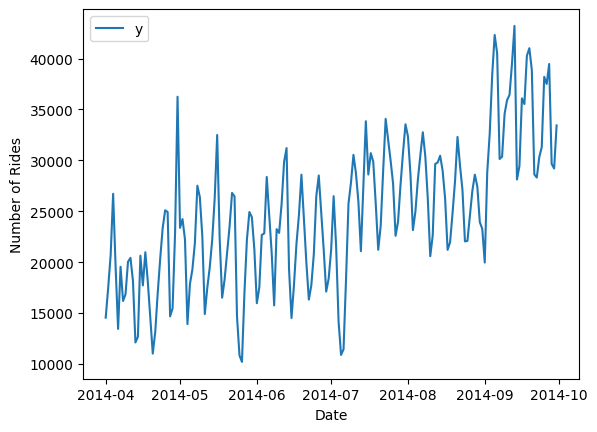

In [34]:
uberbyday.plot(x="ds", y="y")
pl.xlabel('Date')
pl.ylabel('Number of Rides')


... caption ...

# DATA PREPARATION 2: stanardize the data
Subtract the mean and divide by the standard eviation the ```y``` column. Although this is not strictly necessary to work with the Prophet package, it is in general recommanded not to use large numbers in your analysis. furtehrmore, this will convert the target variable to a floating point, which is a better type for regression

Text(0, 0.5, 'Number of Rides')

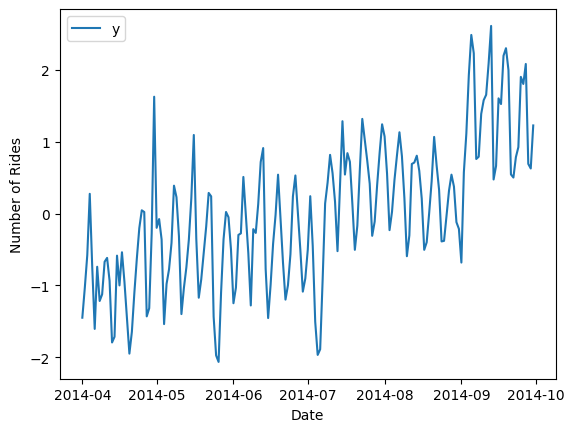

In [36]:
uberbyday.plot(x="ds", y="y");
pl.xlabel('Date')
pl.ylabel('Number of Rides')

...caption...

# DATA ANALYSIS fit the uber rides data with the prophet model.
# MODEL 1: trends and seasonality
The model will look for seasonality and trends automatically. It is a bit of a black box and I dont have a lot of experience with it, but it is really "cutting edge" in this field.
As with any object oriented package, you first need to invoke ```Phrophet()``` to create a model, call it ```simplem```, then fit it to the uber data. Forecast 1 month past the last available datapoint and print the last 5 entries of the resulting dataframe. Plot the forecast, including the uncertainty regions of the forecast and the comonents of the forcast which should be the trend and the weekly seanality. The model should naturally produce these components. If it does not look into the model and the settings by displaying the model methods (e.g. type ```siplemodel.``` and press the tab key.) Remember that ou MUST describe what you see in these plots!


In [42]:
simplem = Prophet()
simplem.fit(uberbyday)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgnlfv6_5/_v5_5hne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgnlfv6_5/9uwftwoj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55287', 'data', 'file=/tmp/tmpgnlfv6_5/_v5_5hne.json', 'init=/tmp/tmpgnlfv6_5/9uwftwoj.json', 'output', 'file=/tmp/tmpgnlfv6_5/prophet_model0bxnzmzn/prophet_model-20250302183507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [46]:
future = simplem.make_future_dataframe(periods=30)
forecast = simplem.predict(future)
uberbyday.tail()

,ds,y,Lat,Lon,Base,time
178,2014-09-26,1.802925,37504,37504,37504,37504
179,2014-09-27,2.081164,39468,39468,39468,39468
180,2014-09-28,0.691101,29656,29656,29656,29656
181,2014-09-29,0.626642,29201,29201,29201,29201
182,2014-09-30,1.225904,33431,33431,33431,33431


Text(89.22222222222221, 0.5, 'Number of Rides (Standardized)')

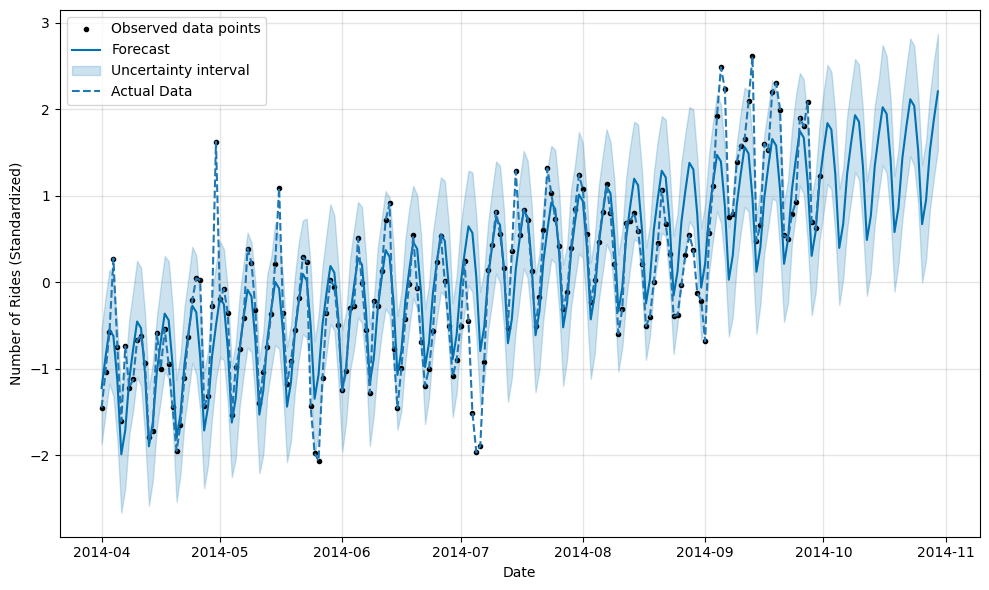

In [50]:
fig1 = simplem.plot(forecast)
pl.plot(uberbyday['ds'], uberbyday['y'], '--', label='Actual Data')
pl.legend()
pl.xlabel('Date')
pl.ylabel('Number of Rides (Standardized)')

... caption ...

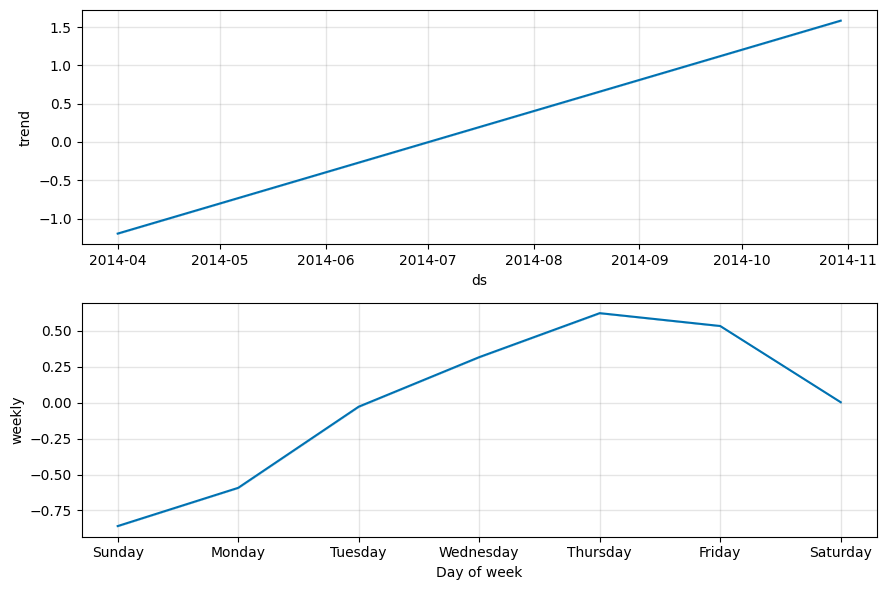

In [51]:
fig2 = simplem.plot_components(forecast)


... caption ...

# DATA ANALYSIS: model validatoin
 Crossvaliate your model and create a function to evaluate the goodness of fit of your model.


Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations. Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we do not have the uncertainties to put them in the chi2 formula (we could create them from count statistics, but I wont ask you to) so assume the uncertainties are $\sigma$= 1.



NOTE: If your uncertainties are estimated correctly and you model is perfect the reduced chi2 should be rchi2=1. If you  unerestimat the uncertainties the reduced chi2 is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [52]:
diagnostics.cross_validation?

In [72]:
def rchi2(y, ytrue):
  # Evaluates the goodness of fit of a Prophet model using cross-validation and reduced chi-squared.
  # ReturnsReduced chi-squared values.
    sigma = 1  # Assume uncertainties are 1
    chi2 = ((ytrue - y)**2) / (sigma**2)
    rchi2 = sum(chi2) / len(ytrue)
    return rchi2

cvresult_simplem = diagnostics.cross_validation(simplem, horizon='30 days')


INFO:prophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgnlfv6_5/sv8r_5hv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgnlfv6_5/9cfo6w99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15067', 'data', 'file=/tmp/tmpgnlfv6_5/sv8r_5hv.json', 'init=/tmp/tmpgnlfv6_5/9cfo6w99.json', 'output', 'file=/tmp/tmpgnlfv6_5/prophet_modelaby43bg5/prophet_model-20250302190424.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:04:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgnlfv6_5/m7zniu_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgnlfv6_5/fka07pwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [73]:
rchi2(cvresult_simplem.yhat, cvresult_simplem.y)

0.46017403994569045

# DATA ACQUISITION 2: OPTIONAL TASK download exogenous variable data.
One may guess that weather would affect the number of rides: a trivial example is that if it rains people are less likely to walk. It might not be that trivial tho, maybe if it  rains people are altogether less likely to go out.

Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests).
an install and import the ```wwo_hist``` package

Save your key in a separate file and read it in. For example, you can create a file ```my_apis.csv``` in the same folder where you are working and the content of the file can be ```wwo,XXXXXXXXXXXXXXXXX```

This should download a ```New+york,ny.csv``` file which you can then read in. Convert the atetime entry to pd.datetime as you did before and merge the uber reides and the weather dataframe on the date feature. YOud rataframe should now have columns ```y, ds, tempC, precipMM```. You should stanardize the tempC and precipMM features as you did for the number of rides.

Plot each feature.

In [74]:
!pip install wwo_hist

In [75]:
from wwo_hist import retrieve_hist_data

In [76]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [77]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [79]:
ls


'1 - Introduction to Measurement and Error (1).pdf'  'Lab Data'/
'Chakraborty_rochester_0188E_11631 (1).pdf'          'Magnetic_sensing_Bivek (1).pdf'
'Colab Notebooks'/                                   'Marriage .mov'
'Copy of SPEAK Test Strategies (1).gdoc'              MLTSA25/
'Copy of SPEAK Test Strategies (2).gdoc'             'SolidWorks Files'@
'Copy of SPEAK Test Strategies.gdoc'                 'Syllabus PHYS221_24F (1).pdf'
'Copy of Week #1 Peer Feeback Form .gdoc'            'TA Schedule PHYS227.gsheet'
'Copy of Week #2 ITA Peer Feedback Form.gdoc'         Test.gdoc
'Electrodynamics PHYS809'/                           'Untitled spreadsheet.gsheet'
 kaggle.json                                         'तिमी र म.mp3'


In [78]:
# prompt: complete this:
# frequency = ... #fewquency in hours
# start_date = ...
# end_date = ...
# api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
# location_list = ['New+york,ny']
# hist_weather_data = retrieve_hist_data(api_key,
#                                 location_list,
#                                 start_date,
#                                 end_date,
#                                 frequency,
#                                 location_label = False,
#                                 export_csv = True)

frequency = 24 #frequency in hours
start_date = '01-APR-2014'
end_date = '30-SEP-2014'
api_key = "434f462dadc8448cba3191344250203"
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)


FileNotFoundError: [Errno 2] No such file or directory: 'my_apis.csv'

In [ ]:
frequency = ... #fewquency in hours
start_date = ...
end_date = ...
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)

In [ ]:
weather = pd.read_csv("New+york,ny.csv")...

In [ ]:
uberweather = uberbyday.merge(weather, ...


In [ ]:
#leave
uberweather

,y,ds,tempC,precipMM
2014-04-01,-1.521465,2014-04-01,-1.959822,-0.484962
2014-04-02,-1.136392,2014-04-02,-1.959822,-0.430609
2014-04-03,-0.711997,2014-04-03,-1.766830,-0.484962
2014-04-04,0.078797,2014-04-04,-3.117776,0.737969
2014-04-05,-0.867183,2014-04-05,-2.345807,-0.457786
...,...,...,...,...
2014-09-28,0.465711,2014-09-28,0.742069,-0.484962
2014-09-29,0.405872,2014-09-29,0.356084,-0.457786
2014-09-29,0.405872,2014-09-29,0.356084,-0.457786
2014-09-30,0.962176,2014-09-30,-0.222892,-0.267552


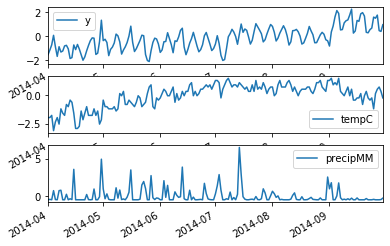

In [ ]:
fig, ax = pl.subplots(3)
uberweather.plot(y="y", ax=ax[0])
uberweather.plot(y="tempC", ax=ax[1])
uberweather.plot(y="precipMM", ax=ax[2])

...caption...

   # MODEL 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [ ]:
regrm = Prophet()
regrm.add_regressor(...
regrm.add_regressor(...

In [ ]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


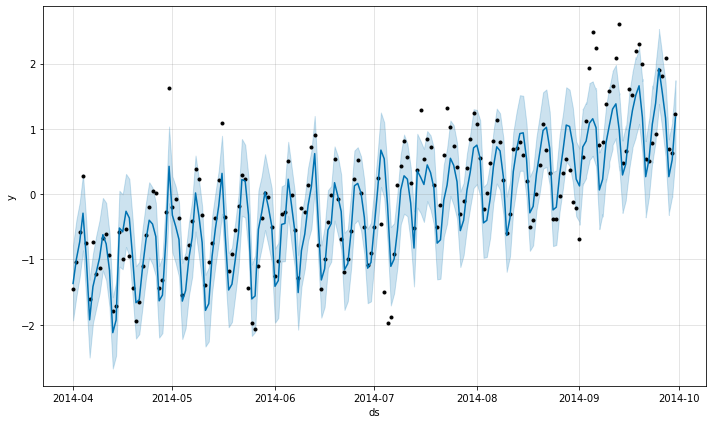

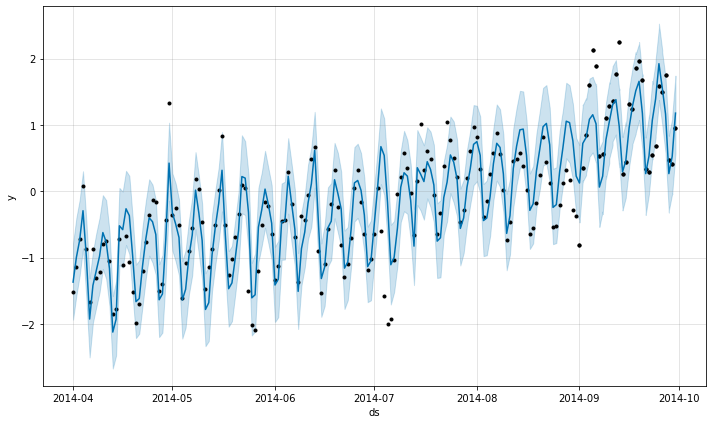

In [ ]:
nowcast = regrm.predict(uberweather)
simplem.plot(nowcast)
regrm.plot(nowcast);


...caption...

In [ ]:
...

In [ ]:
rchi2...

# MODEL 3 add holidays
Holiday of course affect traffic and ridership. Prophoet has very convenient functionality to put in holidays! This a huge simplification of the workflow in timeseries analysis! add holidays for ths us with the model ```model.add_country_holidays()``` which takes argument ```country_name="US"``` in the case of the US. Once again, fit, predict, plot, crossvalidate, calculate and compare the reduced chi2


In [ ]:
regholm ...

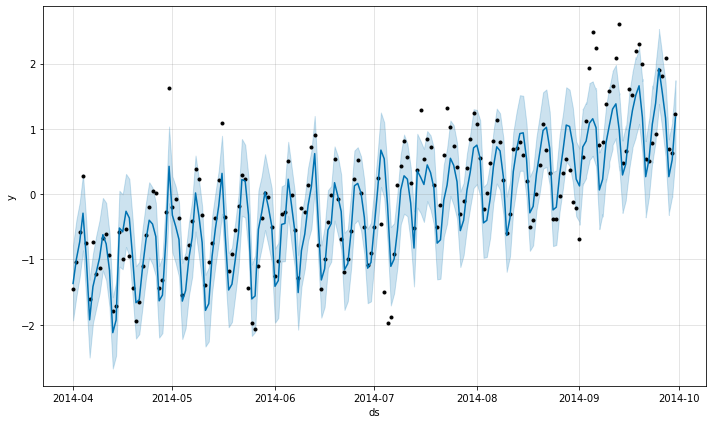

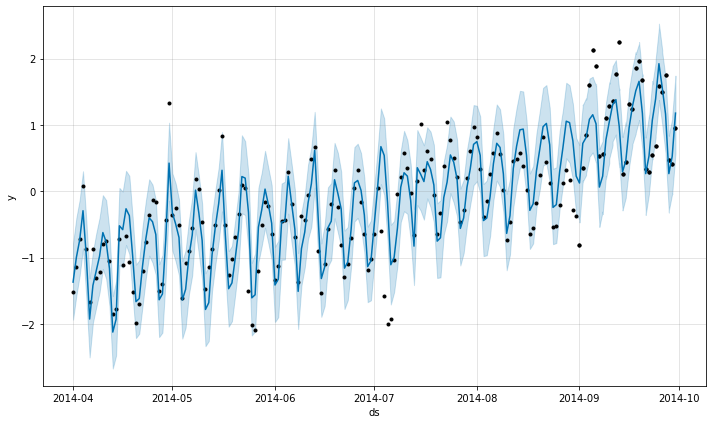

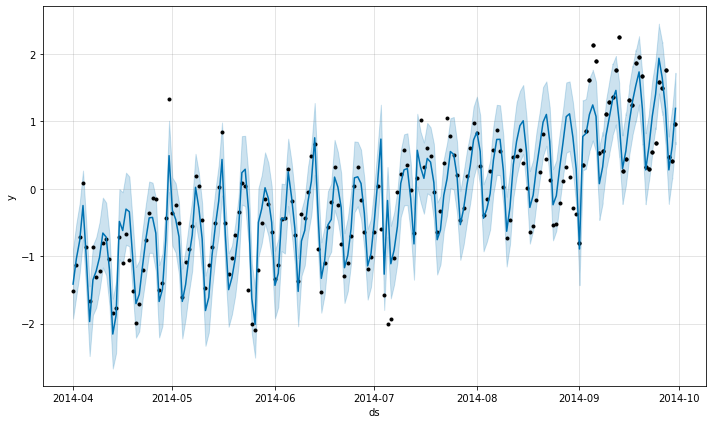

In [ ]:
...

...caption...

In [ ]:
rchi2...

# MODEL 4: this whole thing can be done with MCMC optimization in a fully bayesian framework.
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

In [ ]:
regmcmc = Prophet(mcmc_samples=5000)
...

In [ ]:
rchi2...